In [ ]:
!pip install tensorflow==1.15.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -q lucid>=0.2.3
!pip install -q moviepy

In [ ]:
 !pip install imageio==2.4.1
 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install PyOpenGL PyOpenGL_accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import json
import moviepy.editor as mvp
from google.colab import files
import tensorflow.compat.v1.gfile as gfile
import lucid.misc.io.showing as show
import math

In [ ]:
from lucid.misc.gl.glcontext import create_opengl_context

# Now it's safe to import OpenGL and EGL functions
import OpenGL
import OpenGL.GL as gl
from OpenGL.GLU import *


# create_opengl_context() creates GL context that is attached to an
# offscreen surface of specified size. Note that rendering to buffers
# of different size and format is still possible with OpenGL Framebuffers.
#
# Users are expected to directly use EGL calls in case more advanced
# context management is required.
WIDTH, HEIGHT = 800,800
create_opengl_context((WIDTH, HEIGHT))
    
# OpenGL context is available here.

print(gl.glGetString(gl.GL_VERSION))
print(gl.glGetString(gl.GL_VENDOR)) 
#print(gl.glGetString(gl.GL_EXTENSIONS))

b'4.6.0 NVIDIA 460.32.03'
b'NVIDIA Corporation'


In [ ]:
# Let's render something!
gl.glClear(gl.GL_COLOR_BUFFER_BIT)

gl.glColor3f(.5,.3,.7)
gl.glPointSize(7)

gl.glBegin(gl.GL_LINES)
gl.glVertex2f(0,-1)
gl.glVertex2f(0,1)
gl.glVertex2f(1,0)
gl.glVertex2f(-1,0)
gl.glEnd()

gl.glColor3f(0,.5,0)
gl.glBegin(gl.GL_POINTS)
gl.glVertex2f(.75,.80 )
gl.glVertex2f(.1, 0)
gl.glEnd()


In [ ]:
import random
x_min = 0 
x_max = 7
y_min = -7
y_max = 7

def findzone(x1,y1, x2,y2):  
  zone = 0
  dx = x2 - x1
  dy = y2 - y1
  if abs(dx) >= abs(dy):
    if dx > 0 and dy > 0:
      zone = 0
    elif dx < 0 and dy > 0:
      zone = 3
    elif dx < 0 and dy < 0:
      zone = 4 
    elif dx > 0 and dy < 0:
      zone = 7 
  else: 
    if dx > 0 and dy>  0:
      zone = 1
    elif dx < 0 and dy > 0:
      zone = 2
    elif dx < 0 and dy <0:
      zone = 5
    elif  dx >= 0 and dy < 0:
      zone = 6
  return zone


In [ ]:
def convertToZone0(x1, y1, x2, y2, zone):
  if zone == 0:
    return x1,y1, x2, y2
  elif zone==1:
    return y1, x1, y2,x1
  elif zone == 2:
    return y1, -x1,y2, -x2
  elif zone == 3:
    return -x1, y1, -x2, y2
  elif zone == 4:
    return -x1, -y1, -x2, -y2
  elif zone == 5:
    return -y1, -x1, -y2, -x2 
  elif zone == 6:
    return -y1, x1, -y2, x2
  else:
    return x1, -y1, x2, -y2 


def convertToOrginalZone(x,y,zone):
  a,b =0, 0
  if zone==0:
    a,b = x , y
  elif zone ==1:
    a,b = y,x
  elif zone==2:
    a,b = -y,x
  elif zone ==3:
    a,b = -x,y
  elif zone ==4:
    a,b = -x,-y
  elif zone == 5:
    a,b = -y,-x
  elif zone ==6:
    a,b = y, -x
  else:
    a,b = x, -y
  return a, b



def calculateMidPoint(x1,y1,x2,y2):
  zone =findzone(x1,y1,x2,y2)
  a1, b1, a2, b2 = convertToZone0(x1,y1,x2,y2, zone)
  drawLine(a1,b1,a2,b2, zone) 

In [ ]:
def drawLine(x1, y1, x2, y2, zone):
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    d = 2 * dy - dx
    incE = 2 * dy
    incNE = 2 * dy - 2 * dx
   
    x = x1
    y = y1
    while x <= x2:
        x = x + 1
        if d >= 0:
          d = d+ incNE
          y = y+1
        else:
            d = d + incE
        
        a, b = convertToOrginalZone(x,y,zone)
        state = cohen_sutherland(a/10, b/10, a/10, b/10)
        if state == 'inside':
          gl.glColor3f(.009,.07,.008)
          gl.glPointSize(5)
          gl.glBegin(gl.GL_POINTS)
          gl.glVertex2f(a/100,b/100)
          gl.glEnd()
        else:
          gl.glColor3f(.300, 0, 0)
          gl.glPointSize(5)
          gl.glBegin(gl.GL_POINTS)
          gl.glVertex2f(a/100,b/100)
          gl.glEnd()
          


In [ ]:
def midpointcircle(R,k1,l2,red, green, blue, size):
  d = 1-R
  x = 0
  y = R
  circlePoints(x,y,k1, l2, red, green, blue, size)
  while x <= y:
    if d < 0:
      
      d = d+((2*x)+3)
      x = x+1
   
    else:
      d = d +((2*x)-(2*y)+5)
      x = x+ 1
      y = y-1
 
    circlePoints(x,y,k1,l2,red, green, blue, size) 

In [ ]:
def circlePoints(x,y,c1,c2,red, green, blue, size):
  gl.glPointSize(size)
  x = x/100
  y = y/100
  c1 = c1 /100
  c2 = c2/ 100
  
  
  state = cohen_sutherland(x+c1, y +c2 ,x +c1, y +c2)
  if state == 'inside':
     gl.glColor3f(red, green, blue)
     gl.glBegin(gl.GL_POINTS)
     gl.glVertex2f(x +c1, y +c2)
     gl.glEnd()
  else:                             
     gl.glColor3f(.50, 0, 0)
     gl.glBegin(gl.GL_POINTS)
     gl.glVertex2f(x +c1, y +c2)
     gl.glEnd()  
  
  state = cohen_sutherland( y+c1, x +c2 , y +c1, x +c2)
  if state == 'inside':
     gl.glColor3f(red, green, blue)
     gl.glBegin(gl.GL_POINTS)
     gl.glVertex2f(y +c1, x +c2)
     gl.glEnd()
  else:                               
     gl.glColor3f(.50, 0, 0)
     gl.glBegin(gl.GL_POINTS)
     gl.glVertex2f(y +c1, x +c2)
     gl.glEnd()     
  
  state = cohen_sutherland( -y+c1, x +c2 , -y +c1, x +c2)
  if state == 'inside':
     gl.glColor3f(red, green, blue)
     gl.glBegin(gl.GL_POINTS)
     gl.glVertex2f(-y+c1, x +c2)
     gl.glEnd()
  else:                            
     gl.glColor3f(.50, 0, 0)
     gl.glBegin(gl.GL_POINTS)
     gl.glVertex2f(-y+c1, x +c2)
     gl.glEnd()     

  state = cohen_sutherland( -x+c1, y +c2 , -x +c1, y +c2)
  if state == 'inside':
     gl.glColor3f(red, green, blue)
     gl.glBegin(gl.GL_POINTS)
     gl.glVertex2f( -x+c1, y +c2 )
     gl.glEnd()
  else:                             
     gl.glColor3f(.50, 0, 0)
     gl.glBegin(gl.GL_POINTS)
     gl.glVertex2f( -x+c1, y +c2 )
     gl.glEnd()       

  state = cohen_sutherland( -x+c1, -y +c2 , -x +c1, -y +c2)
  if state == 'inside':
     gl.glColor3f(red, green, blue)
     gl.glBegin(gl.GL_POINTS)
     gl.glVertex2f( -x+c1, -y +c2 )
     gl.glEnd()
  else:                             
     gl.glColor3f(.50, 0, 0)
     gl.glBegin(gl.GL_POINTS)
     gl.glVertex2f(-x+c1, -y +c2 )
     gl.glEnd()       

  state = cohen_sutherland( -y+c1, -x +c2 , -y +c1, -x +c2)
  if state == 'inside':
     gl.glColor3f(red, green, blue)
     gl.glBegin(gl.GL_POINTS)
     gl.glVertex2f(  -y+c1, -x +c2 )
     gl.glEnd()
  else:                             
     gl.glColor3f(.50, 0, 0)
     gl.glBegin(gl.GL_POINTS)
     gl.glVertex2f( -y+c1, -x +c2 )
     gl.glEnd()  

  state = cohen_sutherland( y+c1, -x +c2 , y +c1, -x +c2)
  if state == 'inside':
     gl.glColor3f(red, green, blue)
     gl.glBegin(gl.GL_POINTS)
     gl.glVertex2f(y+c1, -x +c2)
     gl.glEnd()
  else:                             
     gl.glColor3f(.50, 0, 0)
     gl.glBegin(gl.GL_POINTS)
     gl.glVertex2f( y+c1, -x +c2 )
     gl.glEnd()           

  state = cohen_sutherland( x+c1, -y +c2 , x +c1, -y +c2)
  if state == 'inside':
     gl.glColor3f(red, green, blue)
     gl.glBegin(gl.GL_POINTS)
     gl.glVertex2f( x+c1, -y +c2 )
     gl.glEnd()
  else:                             
     gl.glColor3f(.50, 0, 0)
     gl.glBegin(gl.GL_POINTS)
     gl.glVertex2f(x+c1, -y +c2)
     gl.glEnd()            

def cohen_sutherland(x1, y1, x2, y2):
  oc1 =calculate_outcode(x1,y1)
  oc2 =calculate_outcode(x2,y2)
  oc1Dec = int(oc1, base = 2)
  oc2Dec = int(oc2, base = 2)
  while True:
    if (oc1==oc2== "0000"):
      return "inside"
      break
    elif (oc1 !="0000"):
      return "outside"
      break
    else:
      if (oc1!="0000"):
        x1, y1 = find_intersection(oc1,x1,y1,x2,y2)
        oc1 = calculate_outcode(x1,y1)
      else:
        x2, y2 = find_intersection(oc2,x1,y1,x2,y2)
        oc2 = calculate_outcode(x2,y2)

def calculate_outcode(x,y):
  global x_min
  global x_max
  global y_min
  global y_max
  if(x < x_min):
    bit0 = 1
  else:
    bit0 = 0
  if(x > x_max):
    bit1 = 1
  else:
    bit1 = 0
  if(y < y_min):
    bit2 = 1
  else:
    bit2 = 0
  if(y > y_max):
    bit3 = 1
  else:
    bit3 = 0
  return str(bit3) + str(bit2) + str(bit1) + str(bit0)

In [ ]:
def find_intersection(outcode, x1, y1, x2,y2):
  global x_min
  global x_max
  global y_min
  global y_max
  m = (y2-y1)/(x2-x1)
  if(outcode.startswith("1")): 
    y = y_max
    x = x1 + ((1/m)* (y_max - y1))  
  
  elif(outcode.startswith("01")): 
    y = y_min
    x = x1+((1/m)* (y_min - y1))     
  
  elif(outcode.endswith("10")): 
    x = x_max
    y = y1 + (( m * (x_max - x1)))
   
  elif(outcode.endswith("1")):  
    x = x_min
    y = y1 + (( m * (x_min - x1)))   
  return x, y


In [ ]:
def createclippingwindow(x_min, x_max, y_min,y_max):
  gl.glLineWidth(7)
  gl.glColor3f(0, 0, 0)
  gl.glBegin(gl.GL_LINES)
  
  #AROVE
  gl.glVertex2f(x_min/17, y_max/17)
  gl.glVertex2f(x_max/17, y_max/17)
  
  #below
  gl.glVertex2f(x_min/17, y_min/17)
  gl.glVertex2f(x_max/17, y_min/17)
  
  #Right
  gl.glVertex2f(x_max/17, y_max/17)
  gl.glVertex2f(x_max/17, y_min/17)
  
  #left
  gl.glVertex2f(x_min/17, y_max/17)
  gl.glVertex2f(x_min/17, y_min/17)
  gl.glEnd()


In [ ]:

def for_randompoints (x_min,x_max, y_min,y_max, r,g,b,size,count):
  gl.glPointSize(size)

  for i in range(count):
    x = random.randint(x_min, x_max) /100
    y = random.randint(y_min, y_max) /100
    state = cohen_sutherland( x, y, x, y)
    if state == 'inside':
      gl.glColor3f(r, g, b)
      gl.glBegin(gl.GL_POINTS)
      gl.glVertex2f( x, y )
      gl.glEnd()
    else:                             
      gl.glColor3f(.50, 0, 0)
      gl.glBegin(gl.GL_POINTS)
      gl.glVertex2f(x, y)
      gl.glEnd()            

gl.glClearColor(.300, .300,.300,0)
gl.glClear(gl.GL_COLOR_BUFFER_BIT)

#lower body
for_randompoints (-41, 36,-9,-8, .171, .179, .160,5,1000) 
for_randompoints (-14, 8,-9,-8, .142, .147, .134,5,100) 
for_randompoints (-43, 38,-7,-1, .219, .229, .228,5,1000) 
for_randompoints (-40, 36,0,2, .245, .246, .247,5,1000) 
for_randompoints (-33, 29, 3, 4, .245, .246, .247,5,1000) 
for_randompoints (-12, 24, 5, 6, .245, .246, .247,5,500)
for_randompoints(-10, 22, 6, 7, .245, .246, .247,5,500) 
for_randompoints (-7, 16, 7, 9, .245, .246, .247,5,500) 

#WINDOW
for_randompoints (-11, 10, 3, 4, .080, .187, .209,5,200)
for_randompoints(-6, 10, 5, 6, .080, .187, .209,5,200)
for_randompoints (-6, 7, 5, 6, .089, .212, .230,5,200)
for_randompoints (-8, 2, 4, 4, .089, .212, .230,5,200)


#car Body 
calculateMidPoint(38,-6, 36 ,-9) 
calculateMidPoint(38,1,38,-6) 
calculateMidPoint(38,1,15,9) 
calculateMidPoint(10,10,15,9) 
calculateMidPoint(-7,10,10,10) 
calculateMidPoint(-15,4,-7,9) 
calculateMidPoint(-36,4,-15,4) 
calculateMidPoint(-43,0,-36,3) 
calculateMidPoint(-44,-5,-43,-2) 
calculateMidPoint(-44,-8,-44,-5) 
calculateMidPoint(-44,-8,-41,-9) 
calculateMidPoint(-41,-10,-35,-10) 
calculateMidPoint(-25,-10,15,-10) 

#ForTIRES

midpointcircle(5.2,20,-8,.003,.006,.008,16) 
midpointcircle(5.2,-30,-8,.003,.006,.008,16)



#CREATS CLIPPING WINDOW
createclippingwindow(x_min, x_max, y_min,y_max)



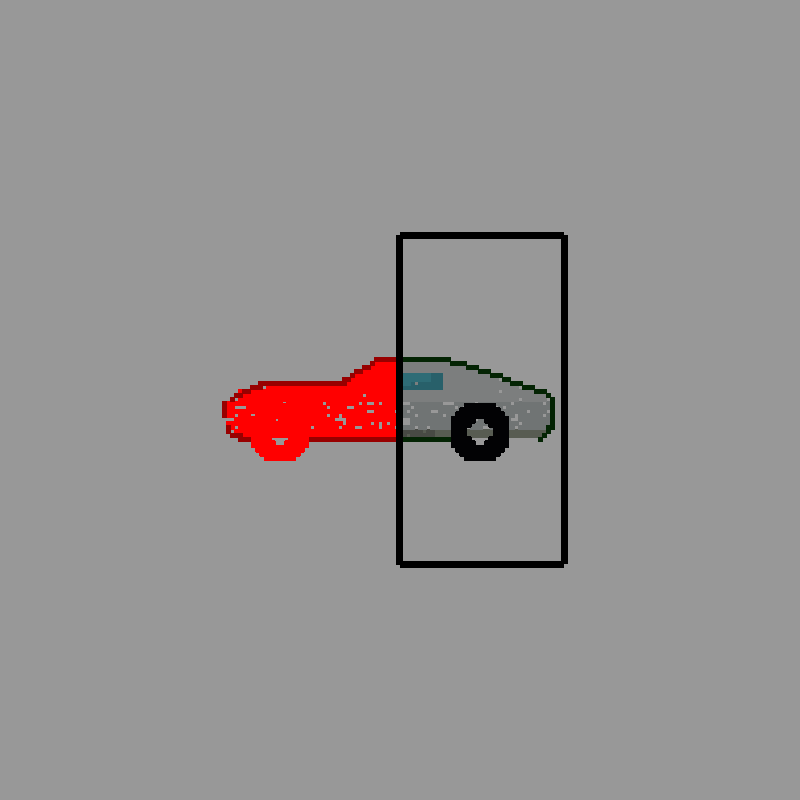

In [ ]:
img_buf = gl.glReadPixelsub(0, 0, WIDTH, HEIGHT, gl.GL_RGB, gl.GL_UNSIGNED_BYTE)
img = np.frombuffer(img_buf, np.uint8).reshape(HEIGHT, WIDTH, 3)[::-1]
show.image(img/255.0)